# Introduction
In this project, we're using data from smartphones and smartwatches to build a model that can tell when someone is sitting down. We'll be using various machine learning techniques to process this sensory data and build a model that can differentiate between sitting and other activities.

# Approach

* **Exploratory data analysis (EDA)**
* **Model training**
* **Model evaluation**
* **Model comparison**
* **Model fine-tuning**
* **Feature importance**
* **Cross-validation**



# Features
* The first row specifies the columns of the file.
* Every other row refers to an example from the user. The examples are sorted according to the primary key - the timestamp.
* The columns:
    * First column is 'timestamp'. This is represented as standard number of seconds since the epoch.
    * Second, come columns for the extracted features.
   Unavailable features are represented with 'nan'.
   The name of each feature contains reference to the sensor it was extracted from, in the form [sensor_name]:[feature_name].
   The current version contains features from the following sensors, with sensor names:
        * raw_acc: Accelerometer from the phone. The 'raw' version of acceleration (as opposed to the decomposed versions of gravity and user-acceleration).   
        * proc_gyro: Gyroscope from the phone. Processed version of gyroscope measurements (the OS calculates a version that removes drift).
        * raw_magnet: Magnetometer from the phone. Raw version (as opposed to bias-fixed version that the OS also provides).
        * watch_acceleration: Accelerometer from the watch.
        * watch_heading: Heading from the compass on the watch.
        * location: Location services. These features were extracted offline for every example from the sequence of latitude-longitude-altitude updates from the example's minute.
            * These features regard only to relative-location (not absolute location in the world) - meaning, they describe variability of movement within the minute.
        * location_quick_features: Location services. These features were calculated on the phone when data was collected.
            * These are available even in cases that the other location features are not because the user wanted to conceal their absolute location coordinates.
            * These quick features are very simple heuristics that approximate the more thoughtful offline features.
        * audio_naive: Microphone. These naive features are simply averages and standard deviations of the 13 MFCCs from the ~20sec recording window of every example.
        * discrete: Phone-state. These are binary indicators for the state of the phone.
            * Notice that time_of_day features are also considered phone-state features (also have prefix 'discrete:'), but their columns appear not right after the other 'discrete' columns.
        * lf_measurements: Various sensors that were recorded in low-frequency (meaning, once per example).

    * Third, come columns for the ground truth labels.
   The values are either 1 (label is relevant for the example), 0 (label is not relevant for the example), or 'nan' (label is considered 'missing' for this example).
   
   Originally, users could only report 'positive' labels (in the original ExtraSensory paper, Vaizman2017a, we assumed that when a label was not reported it is a 'negative' example).
   
   This cleaned version of the labels has the notion of 'missing labels'; Details about how we inferred missing label information is provided in the second paper, Vaizman2017b (see http://extrasensory.ucsd.edu for updated references).
   
   The names of the labels have prefix 'label:'. After the prefix:
   
   If the label name is all capitalized, it is an original label from the mobile app's interface and the values were taken from what the user originally reported.
   
   If the label name begins with 'FIX_', this is a fixes/cleaned version of a corresponding label, meaning that the researchers fixed some of the values that were reported by users because of inconsistencies.
   
   If the label name begins with 'OR_', this is a synthesized label, meaning it did not appear in the app's label menu, but rather the researchers created it as combination (using logical or) of other related labels.
   
   If the label name begins with 'LOC_', this is a fixed/cleaned version of a corresponding label that was fixed by researchers based on absolute location.
      LOC_beach was based on original label 'AT_THE_BEACH'.
	  LOC_home was based on original label 'AT_HOME'.
	  LOC_main_workplace was based on original label 'AT_WORK'.

    * Fourth, the last column is label_source, describing where the original labeling came from in the mobile app's interface. It has 8 possible values:
        * -1: The user did not report any labels for this example (notice, however, that this example may still have labeling for the 'LOC_' labels).
        * 0 : The user used the 'active feedback' interface (reporting immediate future). This example is the first in relevant minute sequence.
        * 1 : The user used the 'active feedback' interface. This example is a continuation of a sequence of minutes since the user started the reported context.
        * 2 : The user used the history interface to label an example from the past.
        * 3 : The user replied to a notification that simply asked to provide any labels.
        * 4 : The user replied to a notification that asked 'In the past [minutes] minutes were you still [recent context]?'. The user replied 'correct' on the phone.
        * 5 : The user replied to a notification that asked 'In the past [minutes] minutes were you still [recent context]?'. The user replied 'not exactly' and then corrected the context labels.
        * 6 : The user replied to a notification that asked 'In the past [minutes] minutes were you still [recent context]?'. The user replied 'correct' on the watch interface.
        
# Tools Required
* pandas for data analysis
* NumPy for numerical operations
* Matplotlib/seaborn for plotting or data visualization.
* Scikit-Learn for machine learning modelling and evaluation.

# Setting Up the Environment

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

# Model Evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay


# Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Saving and Loading Models
save_directory = 'model/'
import joblib
from joblib import dump
from joblib import load

# For reproducibility
np.random.seed(42)

## Loading the Dataset

In [2]:
cwd = "ExtraSensory.per_uuid_features_labels/"

## Combining the entire datset into a single dataframe

The reason for this approach was that the initial exploratory analysis found a lot of missing values and it became increasingly difficult to model with a single csv file. Hence, I decided to combine the entire dataset, aiming to create a more comprehensive and cohesive data structure that would facilitate more effective modeling.

In [3]:
all_files = sorted([file for file in os.listdir(cwd) if file.endswith('.features_labels.csv.gz')])

def load_all_data():
    all_data = []
    for file_name in all_files:
        file_path = os.path.join(cwd, file_name)
        df = pd.read_csv(file_path)
        all_data.append(df)

    # Concatenate all dataframes
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

In [4]:
# Load all data into a single dataframe
df = load_all_data()

In [5]:
df.shape

(377346, 278)

# Exploratory Data Analysis

The goal is to delve deeper into our dataset to better understand its nuances and characteristics. First step is to examine what kind of data do we have, is it categorical or numerical? 
Secondly we'll try and explore if there are any missing values. If yes, then how do we deal with.
Finally, looking at the dataset, can we deduce some correlation between our feature and target variable.

In [6]:
df.head()

,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,...,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,1444079161,0.996815,0.003529,-0.002786,0.006496,0.995203,0.996825,0.998502,1.748756,6.684605,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
1,1444079221,0.996864,0.004172,-0.003110,0.007050,0.994957,0.996981,0.998766,1.935573,6.684603,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
2,1444079281,0.996825,0.003667,0.003094,0.006076,0.994797,0.996614,0.998704,2.031780,6.684605,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
3,1444079341,0.996874,0.003541,0.000626,0.006059,0.995050,0.996907,0.998690,1.865318,6.684605,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
4,1444079431,0.997371,0.037653,0.043389,0.102332,0.995548,0.996860,0.998205,0.460806,6.683904,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2


In [7]:
df.columns.to_list()

['timestamp',
 'raw_acc:magnitude_stats:mean',
 'raw_acc:magnitude_stats:std',
 'raw_acc:magnitude_stats:moment3',
 'raw_acc:magnitude_stats:moment4',
 'raw_acc:magnitude_stats:percentile25',
 'raw_acc:magnitude_stats:percentile50',
 'raw_acc:magnitude_stats:percentile75',
 'raw_acc:magnitude_stats:value_entropy',
 'raw_acc:magnitude_stats:time_entropy',
 'raw_acc:magnitude_spectrum:log_energy_band0',
 'raw_acc:magnitude_spectrum:log_energy_band1',
 'raw_acc:magnitude_spectrum:log_energy_band2',
 'raw_acc:magnitude_spectrum:log_energy_band3',
 'raw_acc:magnitude_spectrum:log_energy_band4',
 'raw_acc:magnitude_spectrum:spectral_entropy',
 'raw_acc:magnitude_autocorrelation:period',
 'raw_acc:magnitude_autocorrelation:normalized_ac',
 'raw_acc:3d:mean_x',
 'raw_acc:3d:mean_y',
 'raw_acc:3d:mean_z',
 'raw_acc:3d:std_x',
 'raw_acc:3d:std_y',
 'raw_acc:3d:std_z',
 'raw_acc:3d:ro_xy',
 'raw_acc:3d:ro_xz',
 'raw_acc:3d:ro_yz',
 'proc_gyro:magnitude_stats:mean',
 'proc_gyro:magnitude_stats:std

Looking at the above we can safely assume that we can use columns starting with prefix 'label' to correspond to our potential target(y) values. Let us explore this further.


## Feature Engineering and Selection

In [8]:
label_columns = [col for col in df.columns if col.startswith('label:')]
label_df = df[label_columns]

In [9]:
label_df

,label:LYING_DOWN,label:SITTING,label:FIX_walking,label:FIX_running,label:BICYCLING,label:SLEEPING,label:LAB_WORK,label:IN_CLASS,label:IN_A_MEETING,label:LOC_main_workplace,...,label:STAIRS_-_GOING_UP,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS
0,0.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,1.0,1.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN
1,0.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,1.0,1.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN
2,0.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,1.0,1.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN
3,0.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,1.0,1.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN
4,0.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,1.0,1.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looking at the columns above our assumption seems to be right. We see that the columns with prefix "label:" are classified into 1's, 0's and NaN.

Let us calculate the pecentage of missing values which will help us understand the quality of our target variable.

In [10]:
# Calculating the percentage of missing values for each 'label:' column
missing_percentages = df[label_columns].isna().sum() / len(df) * 100

# Sorting the percentages from lowest to highest
sorted_missing_percentages = missing_percentages.sort_values()
sorted_missing_percentages

label:LOC_home                    5.833373
label:SITTING                    18.749901
label:FIX_walking                18.749901
label:OR_standing                18.749901
label:LYING_DOWN                 19.510741
label:EATING                     21.429934
label:SLEEPING                   24.401478
label:TALKING                    25.917858
label:AT_SCHOOL                  31.319267
label:OR_exercise                36.176082
label:COMPUTER_WORK              37.044781
label:IN_A_MEETING               38.726527
label:TOILET                     41.625723
label:COOKING                    44.521474
label:DRESSING                   44.902556
label:LOC_main_workplace         46.540575
label:BATHING_-_SHOWER           46.701436
label:GROOMING                   47.316256
label:OR_indoors                 47.844684
label:WATCHING_TV                47.964998
label:SURFING_THE_INTERNET       48.937315
label:IN_A_CAR                   53.704028
label:ON_A_BUS                   55.205037
label:WITH_

We see that our featureset has a lot of missing values. Therefore we will discard all those labels with 30% missing values and only focus on labels with fewer percentage of missing values.

Let us focus on predicting the label:SITING as it has fewer number of missing data.

In [11]:
df

,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,...,label:STAIRS_-_GOING_DOWN,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source
0,1444079161,0.996815,0.003529,-0.002786,0.006496,0.995203,0.996825,0.998502,1.748756,6.684605,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
1,1444079221,0.996864,0.004172,-0.003110,0.007050,0.994957,0.996981,0.998766,1.935573,6.684603,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
2,1444079281,0.996825,0.003667,0.003094,0.006076,0.994797,0.996614,0.998704,2.031780,6.684605,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
3,1444079341,0.996874,0.003541,0.000626,0.006059,0.995050,0.996907,0.998690,1.865318,6.684605,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
4,1444079431,0.997371,0.037653,0.043389,0.102332,0.995548,0.996860,0.998205,0.460806,6.683904,...,NaN,NaN,0.0,NaN,NaN,NaN,1.0,1.0,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377341,1444234779,1.007886,0.009355,0.012618,0.030905,1.005121,1.008012,1.010024,0.423861,6.684569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
377342,1444234839,1.000400,0.009068,-0.019631,0.032762,0.998186,1.001128,1.003113,0.768680,6.684569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
377343,1444234899,1.026223,0.195112,0.255240,0.379733,0.983684,1.000173,1.030232,1.484173,6.668006,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
377344,1444234959,1.123513,0.273450,0.312818,0.480787,0.966631,1.051232,1.229708,1.808524,6.656521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


## Correlation matrix

Let us try to deduce what features has some positive correlation with the behaviour "SITTING".


In [12]:
# calculating the correlation matrix
correlation_matrix = df.corr()

# Since we are modellig only for SITTING, let us look as sitting_correlation
sitting_correlation = correlation_matrix['label:SITTING']

# Filter for only positive correlations
positive_sitting_correlation = sitting_correlation[(sitting_correlation > 0) & (~sitting_correlation.index.str.startswith('label'))]
positive_sitting_correlation

timestamp                                      0.033548
raw_acc:magnitude_stats:percentile25           0.043631
raw_acc:magnitude_stats:time_entropy           0.092854
raw_acc:magnitude_spectrum:log_energy_band0    0.090146
raw_acc:3d:ro_xy                               0.001802
                                                 ...   
lf_measurements:screen_brightness              0.204674
discrete:time_of_day:between9and15             0.210277
discrete:time_of_day:between12and18            0.283961
discrete:time_of_day:between15and21            0.251741
discrete:time_of_day:between18and24            0.140442
Name: label:SITTING, Length: 104, dtype: float64

In [13]:
sorted_positive_sitting_correlation = positive_sitting_correlation.sort_values(ascending=False)
sorted_positive_sitting_correlation

lf_measurements:light                  0.344915
location:max_speed                     0.301301
discrete:time_of_day:between12and18    0.283961
audio_naive:mfcc1:std                  0.265374
audio_naive:mfcc2:std                  0.265020
                                         ...   
raw_acc:3d:ro_xy                       0.001802
raw_magnet:3d:std_y                    0.001430
location:max_altitude                  0.001089
discrete:ringer_mode:missing           0.000666
discrete:wifi_status:missing           0.000509
Name: label:SITTING, Length: 104, dtype: float64

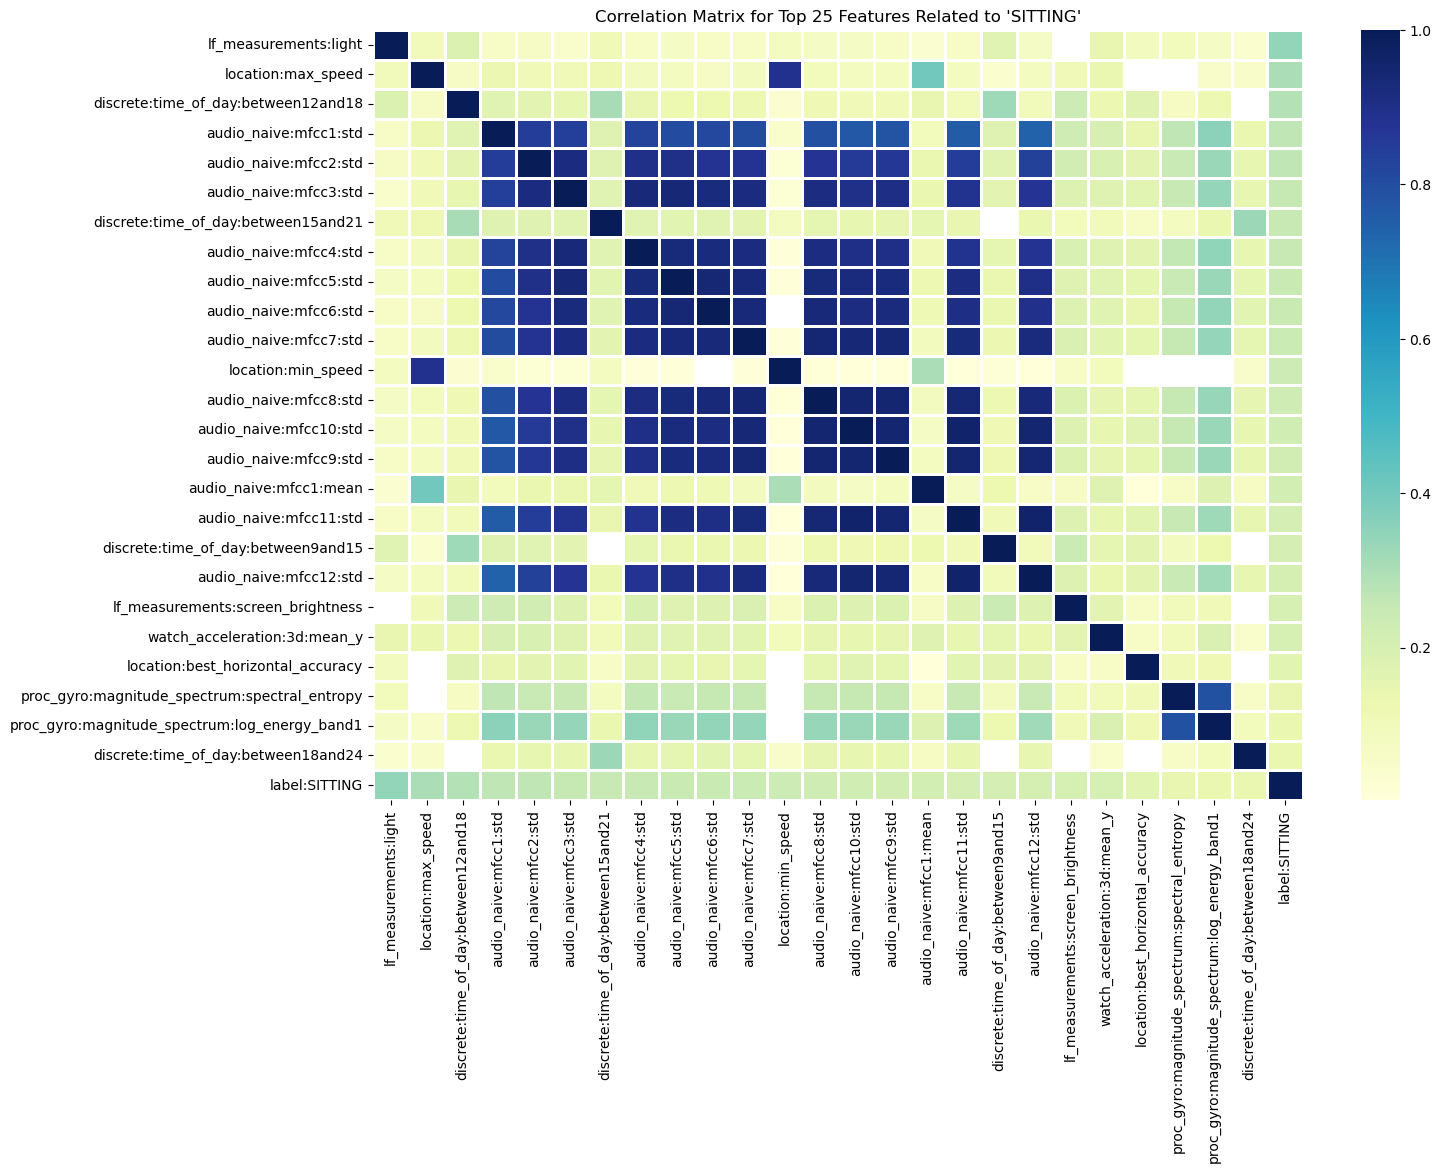

In [14]:
top_25_features = sorted_positive_sitting_correlation.head(25).index.tolist()

# Checking to see whether 'label:SITTING' has any correlation with these features
top_25_features.append('label:SITTING')
filtered_df = df[top_25_features]

# We will filter it further for only positive correlation
correlation_matrix = filtered_df.corr()
correlation_matrix = correlation_matrix[correlation_matrix > 0]

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix,
            annot=False,  
            linewidths=1,
            fmt=".2f",
            cmap="YlGnBu")

plt.title("Correlation Matrix for Top 25 Features Related to 'SITTING'")
plt.show()

Let us explore this further

In [15]:
df['label:SITTING']

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
377341    NaN
377342    NaN
377343    NaN
377344    NaN
377345    NaN
Name: label:SITTING, Length: 377346, dtype: float64

In [16]:
df['label:SITTING'].value_counts()

label:SITTING
0.0    170238
1.0    136356
Name: count, dtype: int64

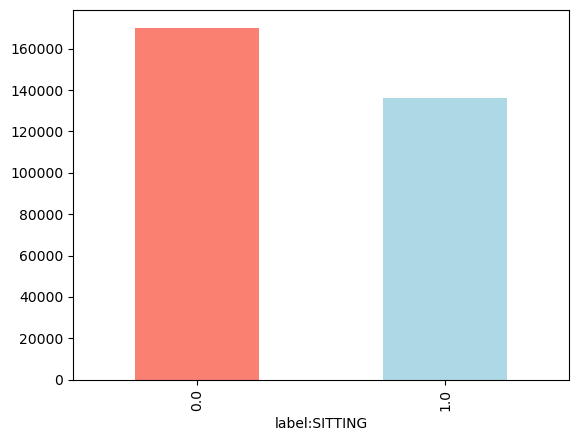

In [17]:
df['label:SITTING'].value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [18]:
df['label:SITTING'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 377346 entries, 0 to 377345
Series name: label:SITTING
Non-Null Count   Dtype  
--------------   -----  
306594 non-null  float64
dtypes: float64(1)
memory usage: 2.9 MB


In [19]:
df['label:SITTING'].isna().sum()

70752

We can see we have 70752 missing values which we need to deal with.

In [20]:
df['label:SITTING'].describe()

count    306594.000000
mean          0.444745
std           0.496938
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: label:SITTING, dtype: float64

# Data Cleaning and Preprocessing

## Handling Missing Data

Removing rows with missing values in target column(SITTING)

In [21]:
df_cleaned = filtered_df.dropna(subset=['label:SITTING'])

In [22]:
df_cleaned['label:SITTING'].isna().sum()

0

## Feature and Target Selection

In [23]:
X = df_cleaned.drop('label:SITTING', axis=1)  # Features
y = df_cleaned['label:SITTING']               # Target

In [24]:
X.shape

(306594, 25)

In [25]:
X

,lf_measurements:light,location:max_speed,discrete:time_of_day:between12and18,audio_naive:mfcc1:std,audio_naive:mfcc2:std,audio_naive:mfcc3:std,discrete:time_of_day:between15and21,audio_naive:mfcc4:std,audio_naive:mfcc5:std,audio_naive:mfcc6:std,...,audio_naive:mfcc1:mean,audio_naive:mfcc11:std,discrete:time_of_day:between9and15,audio_naive:mfcc12:std,lf_measurements:screen_brightness,watch_acceleration:3d:mean_y,location:best_horizontal_accuracy,proc_gyro:magnitude_spectrum:spectral_entropy,proc_gyro:magnitude_spectrum:log_energy_band1,discrete:time_of_day:between18and24
0,NaN,NaN,1.0,1.271966,1.177478,0.670053,0.0,0.389200,0.535904,0.468701,...,-0.012806,0.416881,1.0,0.263832,0.381436,-55.824000,65.0,1.766920,2.818909,0.0
1,NaN,NaN,1.0,1.232031,1.098946,0.669467,0.0,0.499003,0.584068,0.525900,...,1.294372,0.362252,1.0,0.298252,0.381436,-56.096000,65.0,1.455363,2.153223,0.0
2,NaN,NaN,1.0,1.186965,1.251340,0.803958,0.0,0.546688,0.562475,0.559488,...,1.309082,0.430171,1.0,0.330055,0.381436,-57.696000,65.0,1.848755,3.366933,0.0
3,NaN,NaN,1.0,1.410698,1.111916,0.821571,0.0,0.519879,0.572094,0.591143,...,0.182373,0.379887,1.0,0.389737,0.381436,-56.400000,65.0,1.726047,3.325518,0.0
4,NaN,NaN,1.0,2.147232,1.251696,0.902605,0.0,0.777665,0.678277,0.652441,...,0.908387,0.393817,1.0,0.331128,0.381436,-101.187368,65.0,3.425678,3.912588,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377321,NaN,1.74,0.0,1.125063,0.728020,0.482000,0.0,0.373640,0.286663,0.242171,...,1.603140,0.213801,0.0,0.186613,0.000015,NaN,5.0,1.321307,0.788453,0.0
377322,NaN,3.48,0.0,1.184854,0.733604,0.500369,0.0,0.424783,0.346504,0.271555,...,1.690882,0.183018,1.0,0.178549,0.000015,NaN,5.0,1.315108,0.122612,0.0
377323,NaN,2.68,0.0,1.205948,0.795810,0.465592,0.0,0.366454,0.303812,0.252889,...,1.928444,0.198836,1.0,0.207751,0.000015,NaN,5.0,1.389615,0.843170,0.0
377324,NaN,2.24,0.0,0.691122,0.425398,0.369699,0.0,0.289125,0.310188,0.238018,...,-0.155248,0.175390,1.0,0.179356,0.456982,NaN,5.0,1.223915,2.344227,0.0


In [26]:
y

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
377321    0.0
377322    0.0
377323    0.0
377324    0.0
377325    0.0
Name: label:SITTING, Length: 306594, dtype: float64

## Data Transformation and Scaling

Data imputation standardizes our featureset, handling missing data effectively.

In [27]:
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

Scaling ensures that all features contribute equally to the model thereby avoiding skewed results.

In [28]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Splitting the Dataset

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Model Selection

We will choose a diverse range of models to check each algorithms' effectiveness on our dataset.

In [30]:
# Models dictionary
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": xgb.XGBClassifier()
}

Defining a function that loops through each model and outputs its performance.

In [31]:
# Function to fit and score models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

# Model Training and Evaluation

In [32]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)
model_scores

{'Logistic Regression': 0.7262838598150655,
 'KNN': 0.8450072571307425,
 'Random Forest': 0.8593258207081003,
 'Decision Tree': 0.8020841827166131,
 'XGBoost': 0.8283892431383421}

Comparing and plotting each model performance.

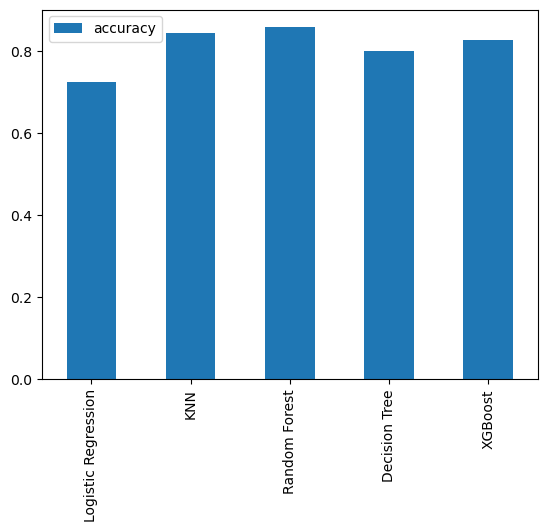

In [33]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar();

We see that RandomForestClassifier performs that best followed by KNN in our baseline performance test. We'll discard the rest and try to further optimize the performance of the two.

# Model Optimization and Hyperparameter Tuning

## Tuning KNeighborsClassifier by hand

In [ ]:
# # Creating a list of train scores
# train_scores = []

# # Creating a list of test scores
# test_scores = []

# neighbors = range(1, 11) # 1 to 10

# knn = KNeighborsClassifier()

# # Loop through different neighbors
# for i in neighbors:
#     knn.set_params(n_neighbors = i) # set neighbors value
#     knn.fit(X_train, y_train)
#     train_scores.append(knn.score(X_train, y_train))
#     test_scores.append(knn.score(X_test, y_test))

In [ ]:
# # Save the train scores
# dump(train_scores, save_directory + 'knn_train_scores.joblib')
# print('Train scores saved'))

# # Save the test scores
# dump(test_scores, save_directory + 'knn_test_scores.joblib')
# print('Test scores saved'))

# # Save the KNN model
# dump(knn, save_directory + 'knn_model.joblib')
# print('KNN model saved'))

In [34]:
# Load the train scores
train_scores = load(save_directory + 'knn_train_scores.joblib')
print('Train scores loaded')

# Load the test scores
test_scores = load(save_directory + 'knn_test_scores.joblib')
print('Test scores loaded')

# Load the KNN model
knn = load(save_directory + 'knn_model.joblib')
print('KNN model loaded')

Train scores loaded
Test scores loaded
KNN model loaded


In [35]:
train_scores

[0.9998613800835796,
 0.9189399653450209,
 0.9186668025685455,
 0.8983467536438692,
 0.8948731016206299,
 0.8859158087860565,
 0.8829436346957497,
 0.8773050657425339,
 0.8746875955560086,
 0.8706513097543573]

In [36]:
test_scores

[0.8365922471012247,
 0.8191751333191996,
 0.8437678370488756,
 0.836999951075523,
 0.8450072571307425,
 0.840473588936545,
 0.8444038552487809,
 0.8403594318237414,
 0.8423001027414015,
 0.8396092565110325]

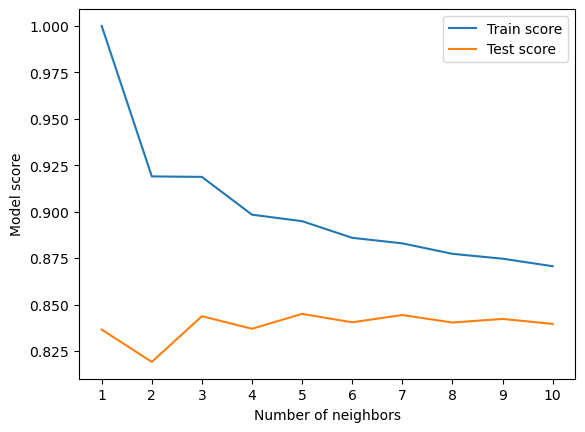

In [37]:
neighbors = range(1, 11) # 1 to 10
plt.plot(neighbors, train_scores, label="Train score")
plt.plot(neighbors, test_scores, label="Test score")
plt.xticks(np.arange(1, 11, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

In [38]:
print(f"Maximum KNN score on the test data: {max(test_scores)*100:.4f}%")

Maximum KNN score on the test data: 84.5007%


In [39]:
model_scores

{'Logistic Regression': 0.7262838598150655,
 'KNN': 0.8450072571307425,
 'Random Forest': 0.8593258207081003,
 'Decision Tree': 0.8020841827166131,
 'XGBoost': 0.8283892431383421}

Looking at the graph, n_neighbors = 5 seems best. But when we compare it with our base model we do not see any improvement in accuracy. So we will stop tuning it further.

Let us try and tune our best model i.e RandomForest Classifier

## Tuning Random Forest Classifier with RandomizedSearchCV

In [ ]:
# rf_grid = {
#     "n_estimators": np.arange(10, 500, 50),
#     "max_depth": [None, 3, 5, 10],
#     "min_samples_split": np.arange(2, 20, 2),
#     "min_samples_leaf": np.arange(1, 20, 2)
# }

In [ ]:
# rs_rf = RandomizedSearchCV(RandomForestClassifier(),
#                            param_distributions=rf_grid,
#                            cv=3,
#                            n_iter=10,
#                            verbose=True,
#                            n_jobs=-1)

# # Fit random hyperparameter search model
# rs_rf.fit(X_train, y_train);

In [ ]:
# # Save the RandomizedSearchCV object for RandomForestClassifier
# dump(rs_rf, save_directory + 'random_forest_random_search_model.joblib')
# print('RandomizedSearchCV model saved'))

In [40]:
# Load the RandomizedSearchCV object for RandomForestClassifier
rs_rf = load(save_directory + 'random_forest_random_search_model.joblib')
print('RandomizedSearchCV object for RandomForestClassifier loaded')

RandomizedSearchCV object for RandomForestClassifier loaded


In [41]:
# Best parameters
rs_rf.best_params_

{'n_estimators': 310,
 'min_samples_split': 4,
 'min_samples_leaf': 11,
 'max_depth': None}

In [42]:
# Evaluating the randomized search random forest model
rs_rf.score(X_test, y_test)

0.8445017042026126

In [43]:
model_scores

{'Logistic Regression': 0.7262838598150655,
 'KNN': 0.8450072571307425,
 'Random Forest': 0.8593258207081003,
 'Decision Tree': 0.8020841827166131,
 'XGBoost': 0.8283892431383421}

We don't see any improvement in scores after hyperparamter tuning. Infact we observe that the baseline model performs better. Hence, we will stop modeling further.

# Final Model Evaluation

We'll make predictions on the test data

In [44]:
y_preds = rs_rf.predict(X_test)

In [45]:
y_preds

array([1., 1., 1., ..., 0., 1., 0.])

In [46]:
y_test

287855    1.0
19744     1.0
54685     1.0
261262    0.0
139215    1.0
         ... 
326981    0.0
333000    0.0
62508     0.0
197346    1.0
120297    1.0
Name: label:SITTING, Length: 61319, dtype: float64

## ROC Curve

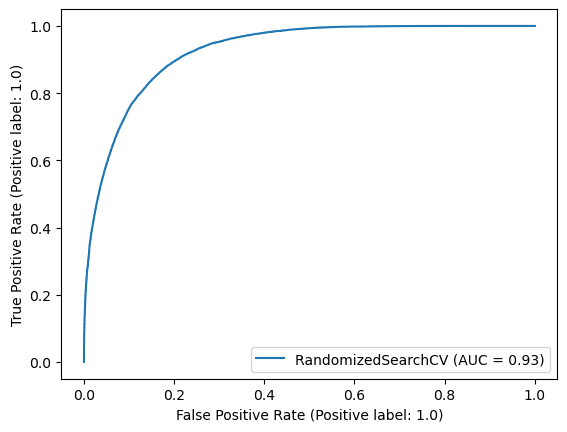

In [47]:
RocCurveDisplay.from_estimator(estimator=rs_rf, 
                               X=X_test, 
                               y=y_test); 

This is great. Our model has a area under the curve (AUC) of 0.93, suggesting that the model has a strong ability to distinguish between the positive and negative classes. The curve approaches the top left corner of the graph, showing a low false positive rate and a high true positive rate.

## Confusion Matrix

In [48]:
print(confusion_matrix(y_test, y_preds))

[[27887  6257]
 [ 3278 23897]]


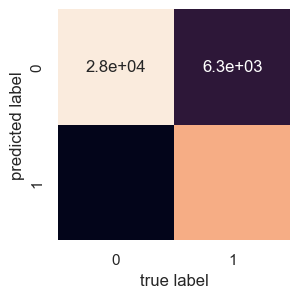

In [49]:
sns.set(font_scale=1) # Increase font size

def plot_conf_mat(y_test, y_preds):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, 
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
    
plot_conf_mat(y_test, y_preds)

The confusion matrix shows that the model is pretty good at guessing right (27887)when something wasn't true and got it right 23897 times when something was true. However, there are 6257 false positives and 3278 false negatives thereby indicating areas for improvement

## Classification Report

In [50]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.89      0.82      0.85     34144
         1.0       0.79      0.88      0.83     27175

    accuracy                           0.84     61319
   macro avg       0.84      0.85      0.84     61319
weighted avg       0.85      0.84      0.84     61319



# Evaluation metrics using cross-validation

In [51]:
rs_rf.best_params_

{'n_estimators': 310,
 'min_samples_split': 4,
 'min_samples_leaf': 11,
 'max_depth': None}

In [52]:
## Instantiate best model with best hyperparameters
clf = RandomForestClassifier(n_estimators = 310, 
                   min_samples_split = 4,
                   min_samples_leaf = 11,
                   max_depth = None)

## Mean Cross Validated Accuracy Score

In [ ]:
# # Cross-validated accuracy score
# cv_acc = np.mean(cross_val_score(clf,
#                          X,a
#                          y,
#                          cv=5, # 5-fold cross-validation
#                          scoring="accuracy")) # accuracy as scoring
# cv_acc

In [ ]:
# # Save the cv_acc value
# dump(cv_acc, save_directory + 'cv_accuracy.joblib')
# print('Cross-validation accuracy saved'))

In [53]:
# Load the saved cv_acc value
cv_acc = load(save_directory + 'cv_accuracy.joblib')
print('Cross-validation accuracy:', cv_acc)

Cross-validation accuracy: 0.750106042581627


## Mean Cross Validated Precsion Score

In [ ]:
# # Cross-validated precision score
# cv_precision = np.mean(cross_val_score(clf,
#                                        X,
#                                        y,
#                                        cv=5, # 5-fold cross-validation
#                                        scoring="precision"))
# cv_precision

In [ ]:
# # Save the cv_precision value
# dump(cv_precision, save_directory + 'cv_precision.joblib')
# print('Cross-validation precision score saved'))

In [54]:
# Load the saved cv_precision value
cv_precision = load(save_directory + 'cv_precision.joblib')
print('Cross-validation precision score:', cv_precision)

Cross-validation precision score: 0.6926955016104406


## Mean Cross Validated Recall Score

In [ ]:
# # Cross-validated recall score
# cv_recall = np.mean(cross_val_score(clf,
#                                     X,
#                                     y,
#                                     cv=5, # 5-fold cross-validation
#                                     scoring="recall"))
# cv_recall

In [ ]:
# # Save the cv_recall value
# dump(cv_recall, save_directory + 'cv_recall.joblib')
# print('Cross-validation recall score saved'))

In [55]:
# Load the saved cv_recall value
cv_recall = load(save_directory + 'cv_recall.joblib')
print('Cross-validation recall score:', cv_recall)

Cross-validation recall score: 0.789316239417369


## Mean Cross Validated F1 Score

In [ ]:
# # Cross-validated F1 score
# cv_f1 = np.mean(cross_val_score(clf,
#                                 X,
#                                 y,
#                                 cv=5, 
#                                 scoring="f1")) 
# cv_f1

In [ ]:
# # Save the cv_f1 value
# dump(cv_f1, save_directory + 'cv_f1.joblib')
# print('Cross-validation F1 score saved'))

In [56]:
# Load the saved cv_f1 value
cv_f1 = load(save_directory + 'cv_f1.joblib')
print('Cross-validation F1 score:', cv_f1)

Cross-validation F1 score: 0.7379484934145412


## Visualizing cross-validated metrics

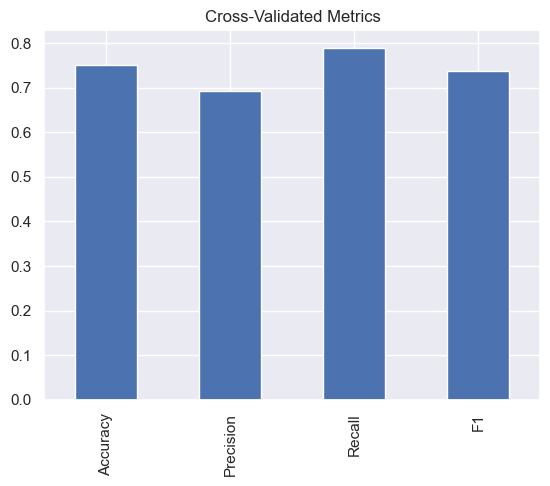

In [57]:
cv_metrics = pd.DataFrame({"Accuracy": cv_acc,
                            "Precision": cv_precision,
                            "Recall": cv_recall,
                            "F1": cv_f1},
                          index=[0])
cv_metrics.T.plot.bar(title="Cross-Validated Metrics", legend=False);

# Feature Importance Analysis

Let's take a look at which parts of the data have the biggest impact on what the model predicts.

In [58]:
# Fit an instance of RandomForestClassifier
clf.fit(X_train, y_train);

In [59]:
feature_importances = clf.feature_importances_

In [60]:
features_dict = dict(zip(df_cleaned.columns, feature_importances))

In [61]:
features_dict

{'lf_measurements:light': 0.07537468077756511,
 'location:max_speed': 0.03403124769656329,
 'discrete:time_of_day:between12and18': 0.060086267772315176,
 'audio_naive:mfcc1:std': 0.06093427369807594,
 'audio_naive:mfcc2:std': 0.058281332172434495,
 'audio_naive:mfcc3:std': 0.041462999725892714,
 'discrete:time_of_day:between15and21': 0.043360900628226826,
 'audio_naive:mfcc4:std': 0.03704440590815199,
 'audio_naive:mfcc5:std': 0.027172904439854543,
 'audio_naive:mfcc6:std': 0.031531589822378185,
 'audio_naive:mfcc7:std': 0.027435684906716325,
 'location:min_speed': 0.02073908608430581,
 'audio_naive:mfcc8:std': 0.025375759641525303,
 'audio_naive:mfcc10:std': 0.02081059009123505,
 'audio_naive:mfcc9:std': 0.021027138241907516,
 'audio_naive:mfcc1:mean': 0.0686234276811381,
 'audio_naive:mfcc11:std': 0.02195100556164256,
 'discrete:time_of_day:between9and15': 0.037462146972628396,
 'audio_naive:mfcc12:std': 0.023618305818491604,
 'lf_measurements:screen_brightness': 0.06278706331454692,

## Sorting and Plotting Features of Importance

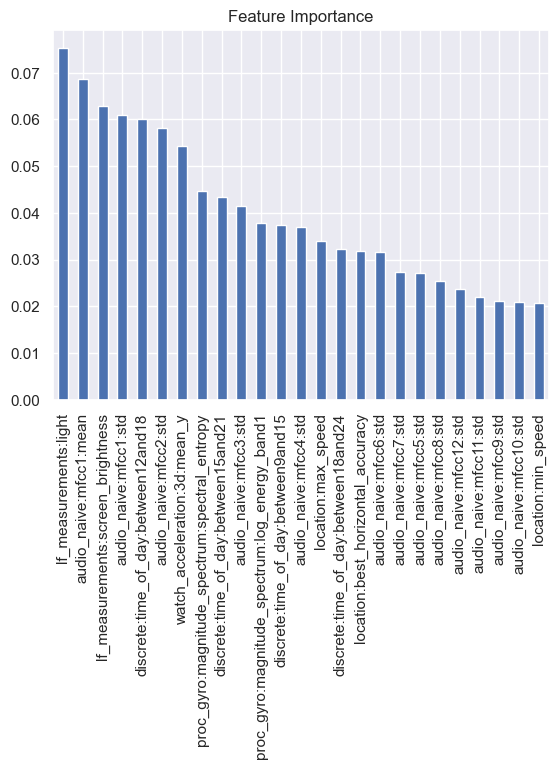

In [62]:
features_df = pd.DataFrame(features_dict, index=[0]).T.sort_values(by=0, ascending=False)
features_df.plot.bar(title="Feature Importance", legend=False);

# References

Major parts of this notebook were inspired from the following github guide:

[Github](https://github.com/mrdbourke/zero-to-mastery-ml/blob/master/section-3-structured-data-projects/end-to-end-heart-disease-classification.ipynb)
